# RUN experiments

In this notebook, we will run all the required experiments using the `Experiment` class, which can be found at `sscode/experiment.py`, and can be seen below:

```python
    class Experiment(object):
        """
        This class Experiment summarizes all the previous work done with the linear, knn and the
        xgboost models, as this class allows the user to perform a detailed analysis of one
        requested model given a set of parameters
        """

        def __init__(self, slp_data, wind_data, # this is the predictor
                     ss_data, # this must have several stations
                     sites_to_analyze: list = sites_to_analyze,
                     model: str = 'linear', # this is the model to analyze
                     model_metrics: list = default_evaluation_metrics,
                     ext_quantile: tuple = default_ext_quantile,
                     pca_attrs: dict = pca_attrs_exp,
                     model_attrs: dict = linear_attrs_exp,
                     pcs_folder: str = data_path+'/pcs',
                     verbose: bool = True):
            """
            As the initializator, the __init__ function creates the instance of the class,
            given a set of parameters, which are described below
            
            ...

            # lets build the experiment!!
```

where it can be seen how, given the sea-level-pressure / wind data, the storm surge (it is preferable to use the Moana v2 hindcast nearshore), all the individual sites to analyze, the type of model that will be used (with its evaluation metrics), and the PCA attributes and the MODEL attributes that will be used to calculate the model, the EXPERIMENTs can be run.

Given these parameters, we construct the object of the class, and then running `execute_cross_model_calculations`, we can calculate all the experiments given the possible combinations!!

```{warning}
Be careful with the ["curse of dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality), as it seems very easy to add more options for the parameters of the models, but once we have more than 3-4 parameters with 2-3 different values, the number of models that will be performed can increase to hundreds!!
```

Below, different code cells with imports, loading functions, visualizations... will appear, but the workflow is similar to all the notebooks in the repository. Once we load the data, we use the pre-built python classes to generate results!!

In the figure below, some results for different locations in New Zealand, and the best performing predictor with multi-linear regression can be found:

```{figure} ../media/images/time-series-plot.png
---
width: 600px
name: time-series-results
---
Results for 5 different locations in the studied domain are shown. SLP panels show the aspect of two different storms approaching the islands of New Zealand, represented by colored lines in the time series plots. These time series show both the real storm surge signal and the reconstructed one with the best performing predictor and the linear model. The scatter plots in the right part show how the whole dataset is reconstructed, for the different locations.
```

In [1]:
# basics
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
import sys, os
sys.path.insert(0, '/Users/administrador/Documents/geocean-nz-ss/')
data_path = '/Users/administrador/Documents/geocean-nz-ss/data/'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_location, \
    default_region, default_region_reduced, default_evaluation_metrics, \
    default_ext_quantile
from sscode.data import Loader, load_moana_hindcast
from sscode.experiment import Experiment

# warnings
import warnings
warnings.filterwarnings('ignore')

# for autocomplete code
%config Completer.use_jedi = False

DATA PATH /Users/administrador/Documents/geocean-nz-ss/data/


## Load the data, SLP and SS

In [2]:
# load the data using the Loader class
load_cfsr_moana_uhslc = Loader(
    data_to_load=('cfsr','moana','uhslc'),
    time_resample='1D',load_winds=(True,None),
    plot=(False,False,False),
    load_predictor_files=(True,(os.environ['SSURGE_DATA_PATH']+'cfsr/CFSR_MSLP_daily.nc',
                                os.environ['SSURGE_DATA_PATH']+'cfsr/CFSR_WINDs_daily.nc'))
)


 loading previously saved atmospheric data from (True, ('/Users/administrador/Documents/geocean-nz-ss/data/cfsr/CFSR_MSLP_daily.nc', '/Users/administrador/Documents/geocean-nz-ss/data/cfsr/CFSR_WINDs_daily.nc')) 


 loading the Moana v2 hindcast data... 


 loading the UHSLC tidal guages... 



In [3]:
load_cfsr_moana_uhslc.predictor_slp, load_cfsr_moana_uhslc.predictand

(<xarray.Dataset>
 Dimensions:    (time: 11354, longitude: 101, latitude: 101)
 Coordinates:
   * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-01-31
   * longitude  (longitude) float32 140.0 140.5 141.0 141.5 ... 189.0 189.5 190.0
   * latitude   (latitude) float32 -70.0 -69.5 -69.0 -68.5 ... -21.0 -20.5 -20.0
 Data variables:
     SLP        (time, latitude, longitude) float64 ...,
 <xarray.Dataset>
 Dimensions:  (time: 8728, site: 1448)
 Coordinates:
   * time     (time) datetime64[ns] 1994-01-17 1994-01-18 ... 2017-12-09
   * site     (site) int64 0 1 2 3 4 5 6 7 ... 1441 1442 1443 1444 1445 1446 1447
 Data variables:
     ss       (time, site) float32 ...
     lon      (site) float64 ...
     lat      (site) float64 ...)

## Create / Run -- Experiment object

In the two cells below, we first choose all the values that will have the different parameters for the model that will be used, and then we create the instance of the class `Experiment`, where different logs will appear before running all the models.

In [9]:
# experiment attributes
# ---------------------
sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [ 
        689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
        1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
        1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)
# sites_to_analyze = load_cfsr_moana_uhslc.predictand.site.values
pca_attrs_exp = {
    'calculate_gradient': [True],
    'winds': [False],
    'time_lapse': [1], 
    'time_resample': ['1D'], # 6H and 12H available...
    'region': [(True,default_region_reduced)]
}
linear_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98]
}
knn_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98],
    'k_neighbors': np.arange(1,22,5) # None calculates the optimum k-neighs
}
xgboost_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98],
    'n_estimators': [50], 'max_depth': [3,9,15,21,27,33,39],
    'min_samples_split': [0.03,0.15,0.3],
    'learning_rate': [0.1], 'loss': ['ls'] # more could be added
}

```{note}
Please check `Experiment` logs before running `execute_cross_model_calculations()`!!
```

In [12]:
# create the experiment
experiment = Experiment(
    load_cfsr_moana_uhslc.predictor_slp, 
    load_cfsr_moana_uhslc.predictor_wind, 
    load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
    sites_to_analyze=sites_to_analyze, 
    model='linear', # model that will be used to predict
    model_metrics=default_evaluation_metrics,
    ext_quantile=default_ext_quantile,
    pca_attrs=pca_attrs_exp,
    model_attrs=linear_attrs_exp,
    pcs_folder='/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/'
)


 The model has been correctly initialized with || model = linear ||             

 and model evaluation metrics = ['bias', 'si', 'rmse', 'rel_rmse', 'ext_rmse', 'ext_rel_rmse', 'pearson', 'rscore', 'spearman', 'ext_pearson', 'ext_rscore', 'ext_spearman', 'pocid', 'tu_test', 'expl_var', 'nse', 'kge', 'kgeprime', 'ext_nse', 'ext_kge', 'ext_kgeprime']             

 pca_params = {'calculate_gradient': [True], 'winds': [False], 'time_lapse': [1], 'time_resample': ['1D'], 'region': [(True, (160, 185, -52, -30))]} 

 model_params = {'train_size': [0.7], 'percentage_PCs': [0.98]}             

 which makes a total of 1 iterations as there are (1, 1, 1, 1, 1, 1, 1) values for each parameter             

 the experiment will be performed in sites = [ 116  200  224  328  378  393  480  488  578  613  689  708  744  780
  803  949  999 1025 1064 1124 1146 1174 1177 1214 1217 1260 1296 1327
 1442]             

 RUN CELL BELOW if this information is correct!!


```{note}
Once the instance of the class is well created, lets run all the models running the cell below
```


 Analyzing site 116!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 116, coords = (array(168.34508816), array(-46.62520765)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/default_region_reduced_no_winds_gradients_1D_tl1.nc
PCs loaded from file

 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



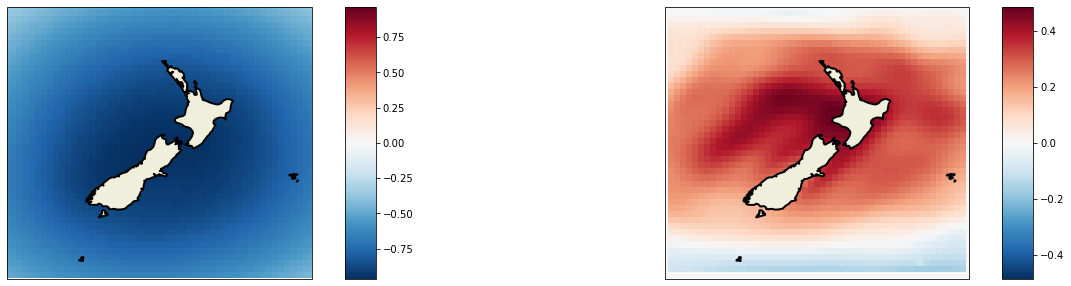

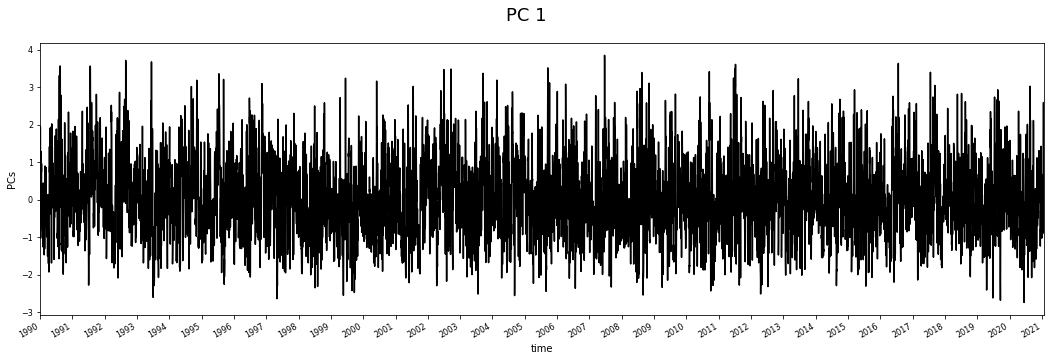


 41 PCs (0.98 expl. variance) will be used to train the model!! 



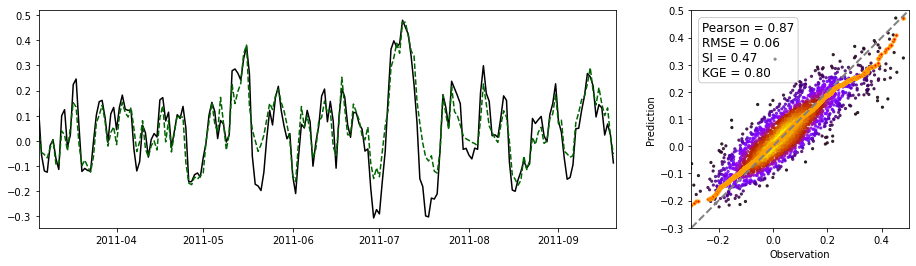

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75007205], KGE = [0.79575498] and KGE_PRIME = [0.75216974]
 R score: 0.75 -- in TEST data

 Analyzing site 200!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 200, coords = (array(166.53148615), array(-46.07851648)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

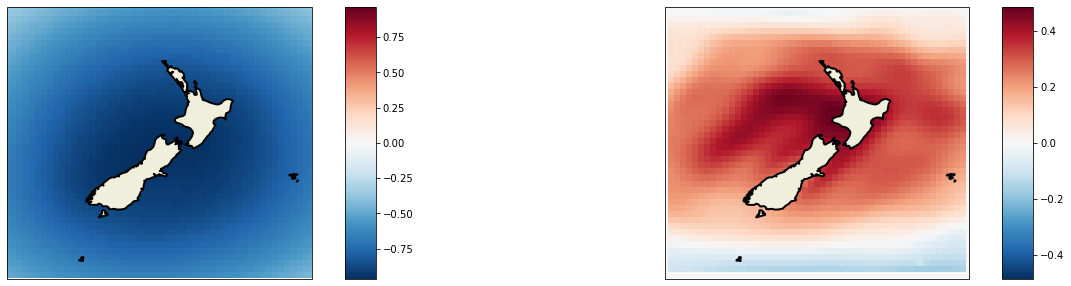

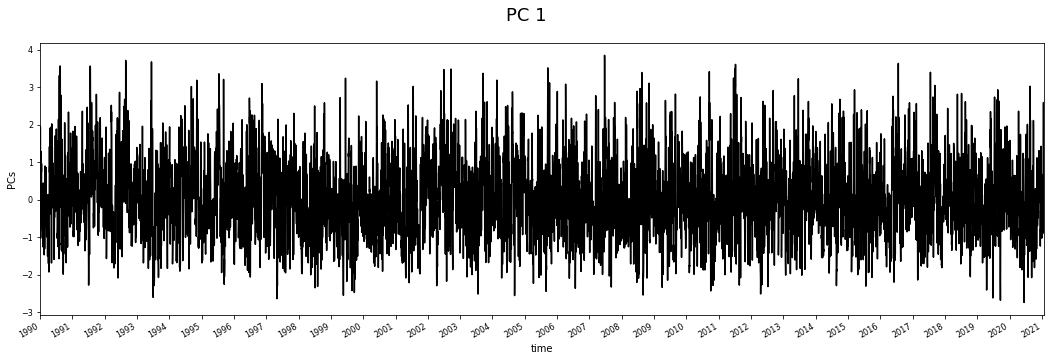


 41 PCs (0.98 expl. variance) will be used to train the model!! 



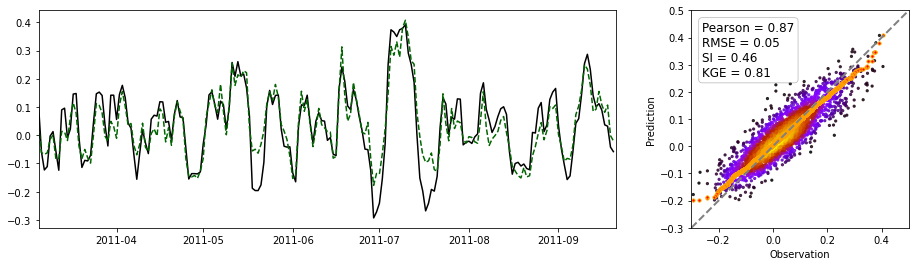

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76383368], KGE = [0.80577575] and KGE_PRIME = [0.75630161]
 R score: 0.76 -- in TEST data

 Analyzing site 224!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 224, coords = (array(170.76322418), array(-45.82435259)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

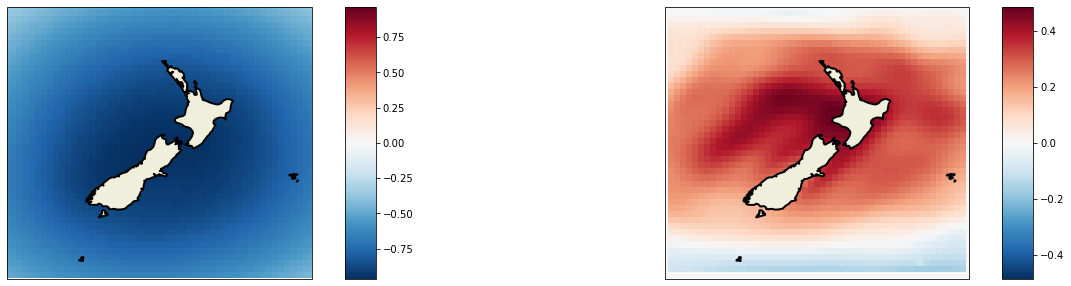

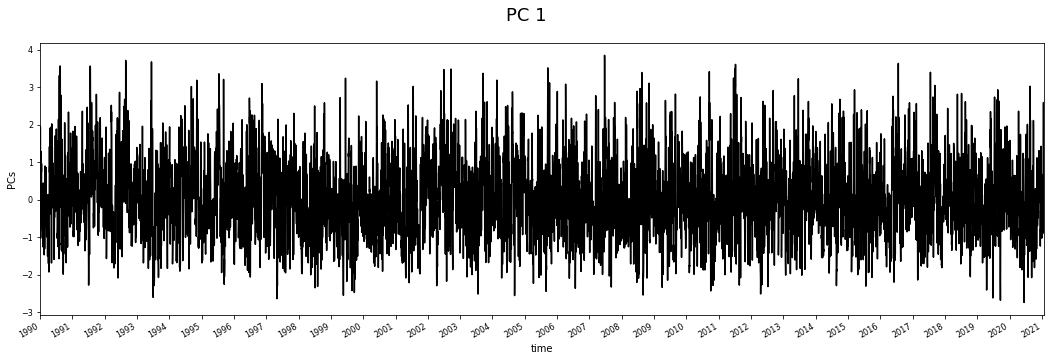


 41 PCs (0.98 expl. variance) will be used to train the model!! 



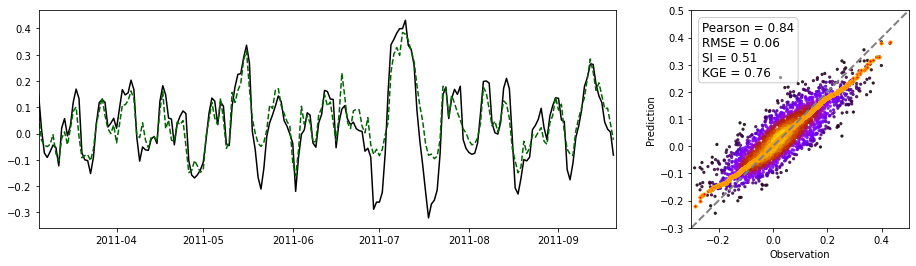

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.71006297], KGE = [0.76086153] and KGE_PRIME = [0.71463679]
 R score: 0.71 -- in TEST data

 Analyzing site 328!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 328, coords = (array(171.30730479), array(-44.36206664)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

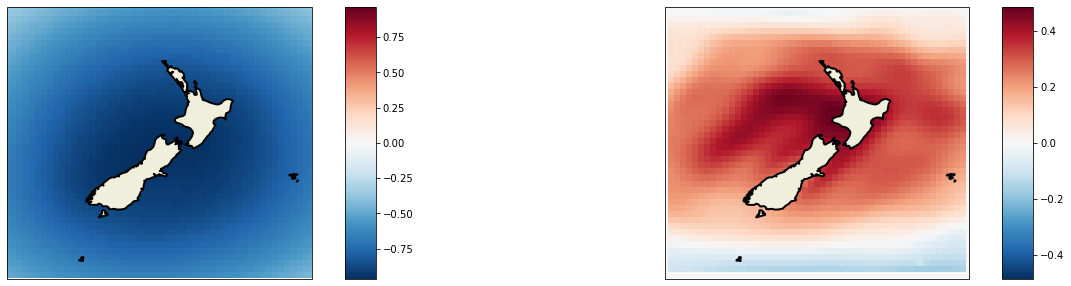

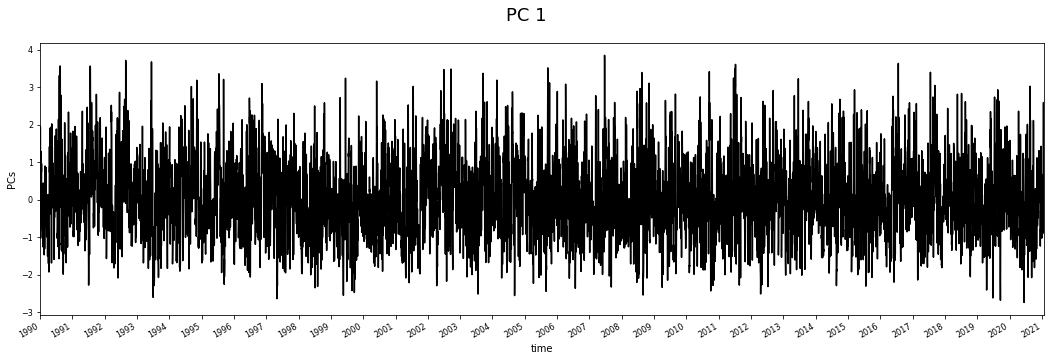


 41 PCs (0.98 expl. variance) will be used to train the model!! 



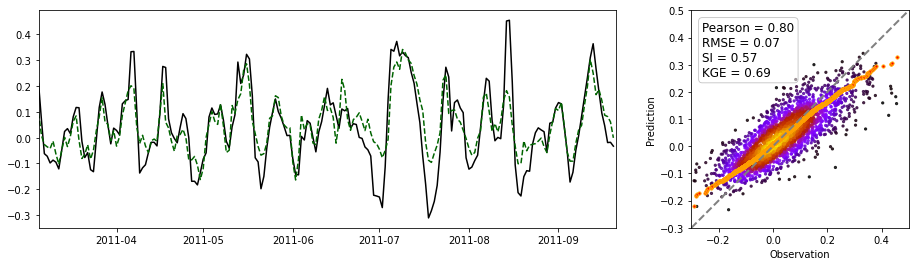

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.64298279], KGE = [0.69463372] and KGE_PRIME = [0.66792478]
 R score: 0.64 -- in TEST data

 Analyzing site 378!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 378, coords = (array(183.63979849), array(-44.01255784)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

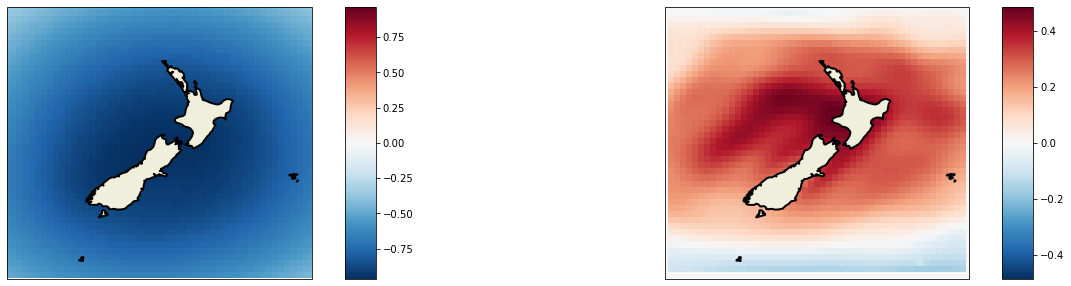

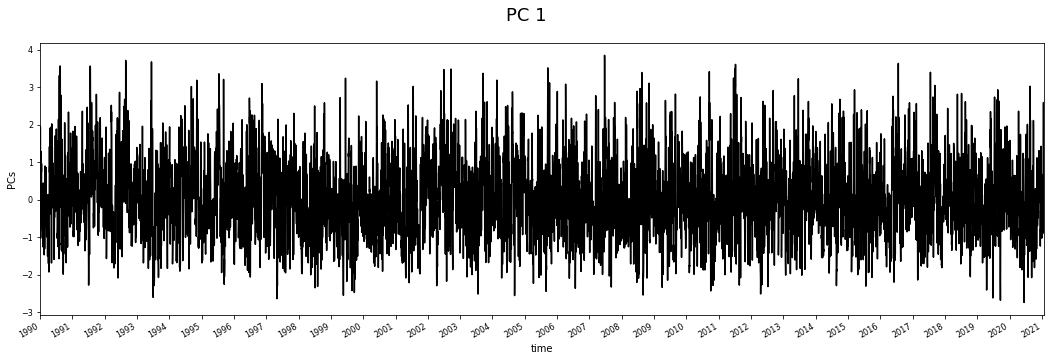


 41 PCs (0.98 expl. variance) will be used to train the model!! 



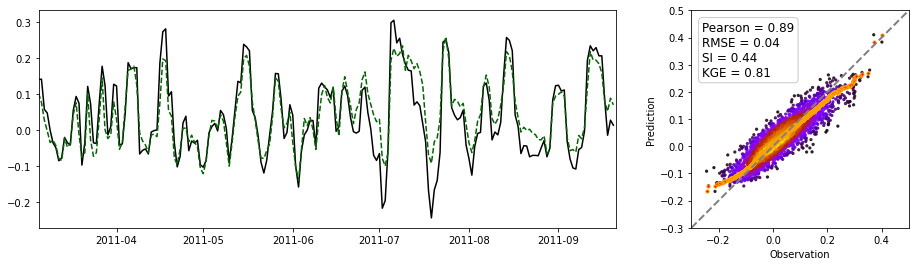

Data comparison is   --   BIAS: -0.00, SI: 0.44, Relative - RMSE: 0.22
 and Correlations (Pearson, Rscore): (0.89, 0.79)
 NSE = [0.78606627], KGE = [0.80909088] and KGE_PRIME = [0.79430503]
 R score: 0.79 -- in TEST data

 Analyzing site 393!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 393, coords = (array(168.58690176), array(-43.92485685)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

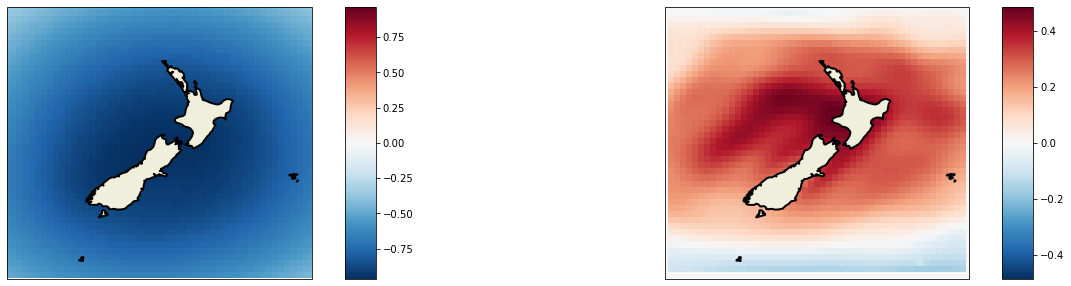

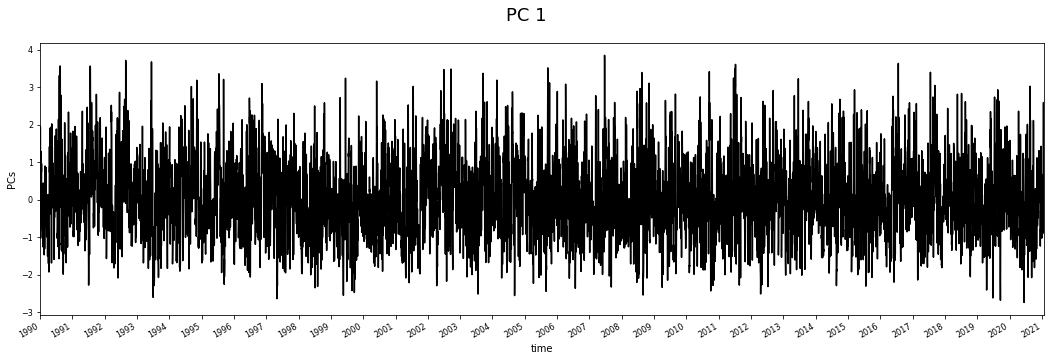


 41 PCs (0.98 expl. variance) will be used to train the model!! 



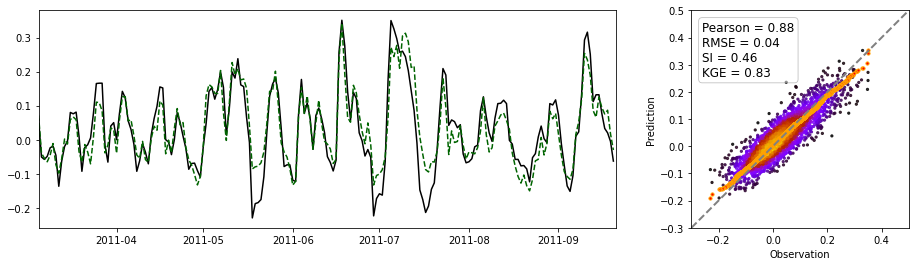

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.88, 0.77)
 NSE = [0.76983519], KGE = [0.82561325] and KGE_PRIME = [0.78500182]
 R score: 0.77 -- in TEST data

 Analyzing site 480!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 480, coords = (array(172.8186398), array(-43.57275821)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss

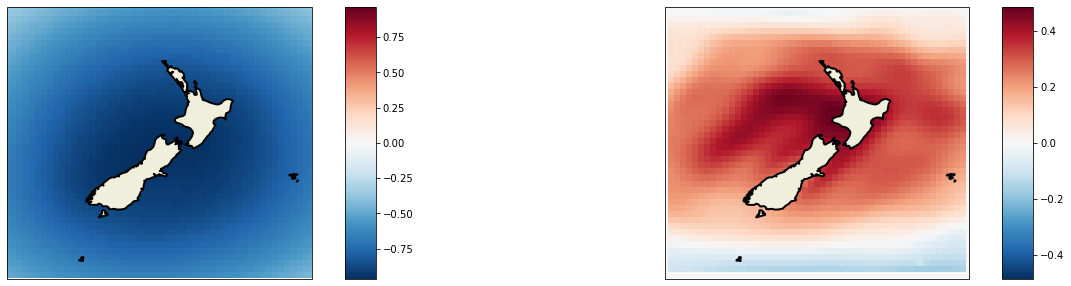

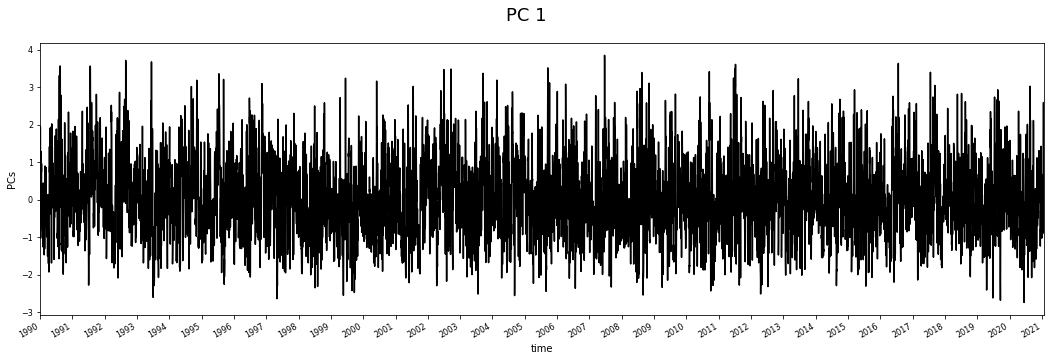


 41 PCs (0.98 expl. variance) will be used to train the model!! 



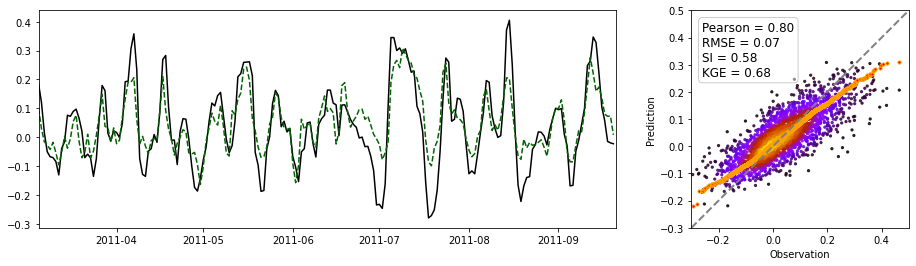

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63244327], KGE = [0.67907128] and KGE_PRIME = [0.66150144]
 R score: 0.63 -- in TEST data

 Analyzing site 488!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 488, coords = (array(172.7581864), array(-43.48440996)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss

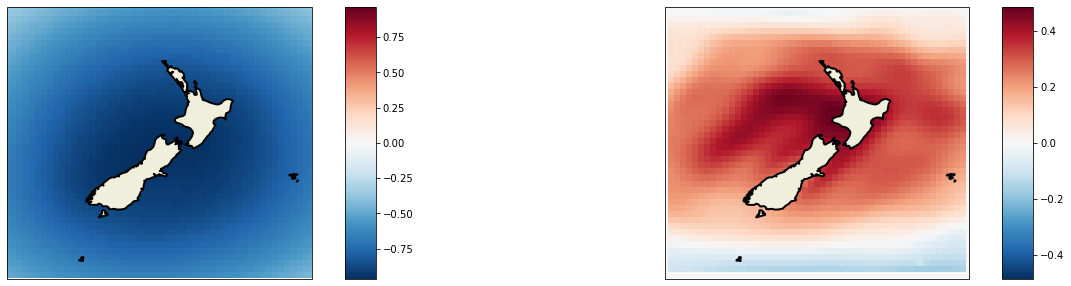

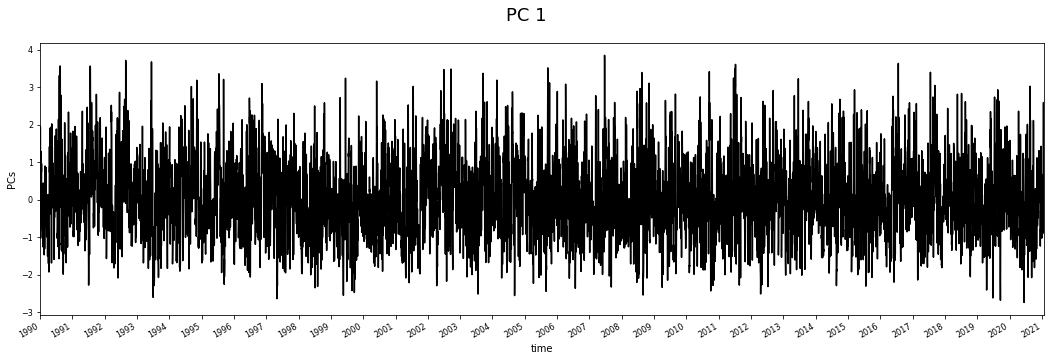


 41 PCs (0.98 expl. variance) will be used to train the model!! 



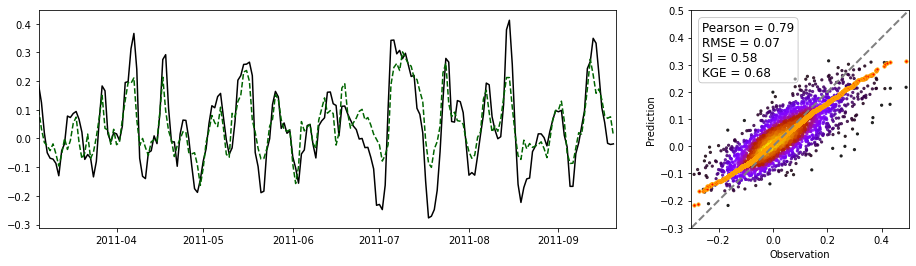

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.63)
 NSE = [0.62908627], KGE = [0.6753719] and KGE_PRIME = [0.65929012]
 R score: 0.63 -- in TEST data

 Analyzing site 578!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 578, coords = (array(173.72544081), array(-42.4141452)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/

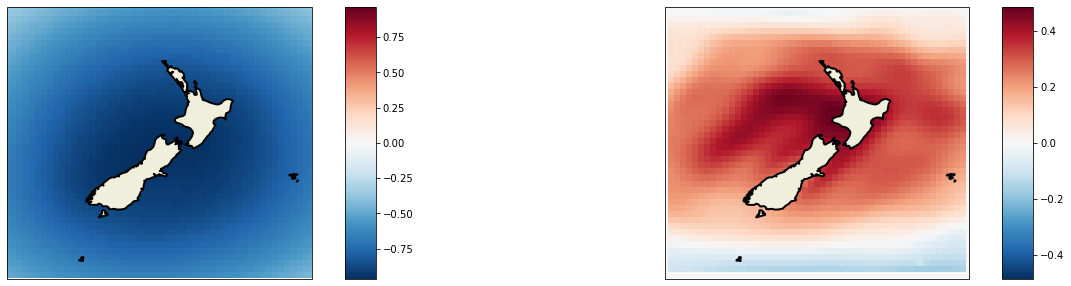

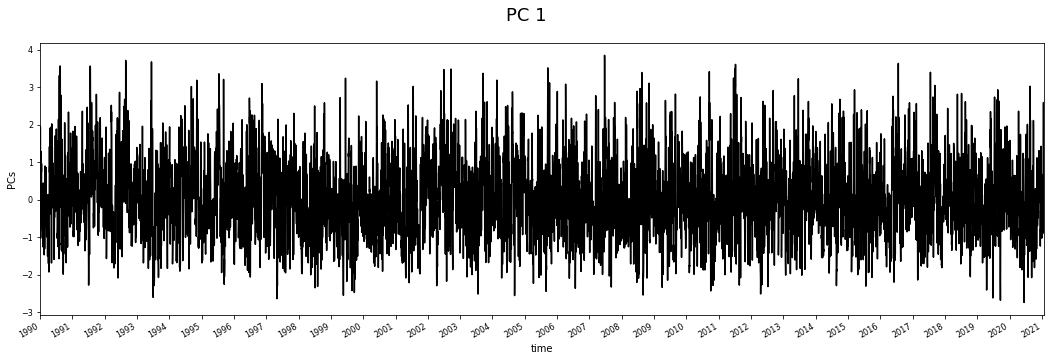


 41 PCs (0.98 expl. variance) will be used to train the model!! 



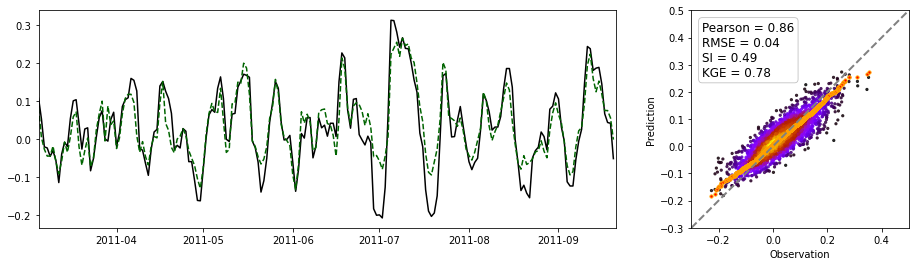

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73638794], KGE = [0.78368021] and KGE_PRIME = [0.75606223]
 R score: 0.74 -- in TEST data

 Analyzing site 613!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 613, coords = (array(171.42821159), array(-41.87204079)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

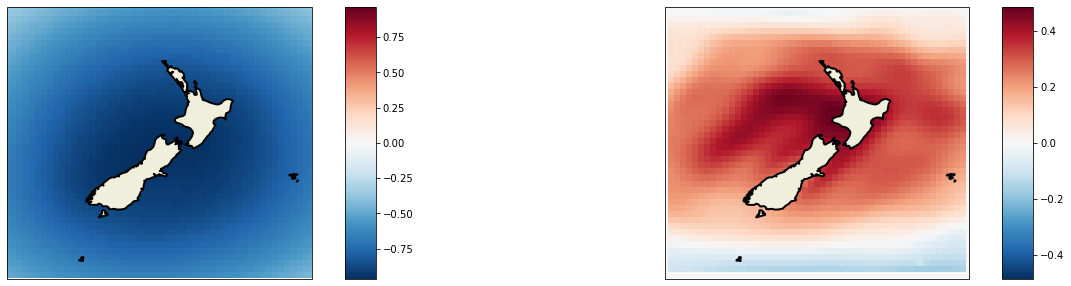

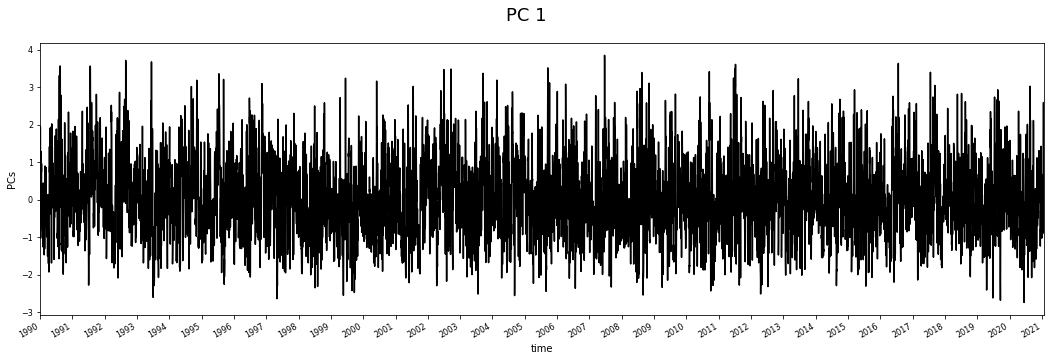


 41 PCs (0.98 expl. variance) will be used to train the model!! 



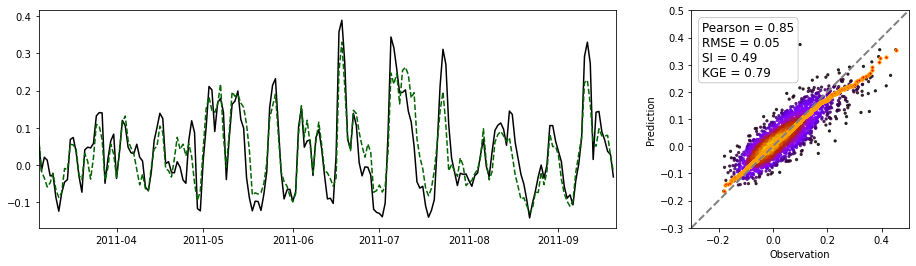

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.7237319], KGE = [0.7870197] and KGE_PRIME = [0.78568463]
 R score: 0.72 -- in TEST data

 Analyzing site 689!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 689, coords = (array(174.75314861), array(-41.37103813)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/

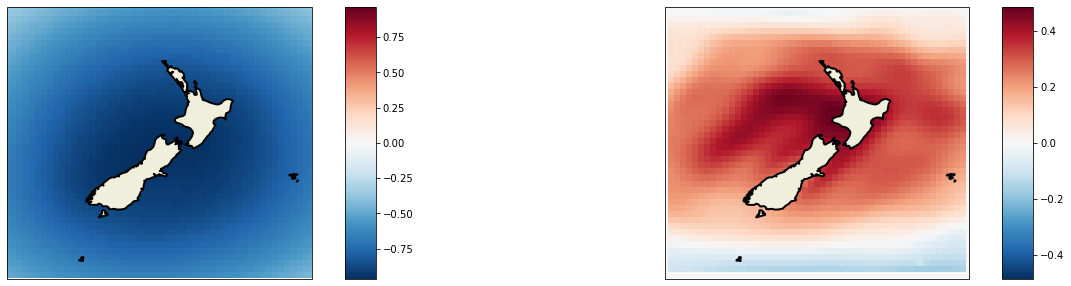

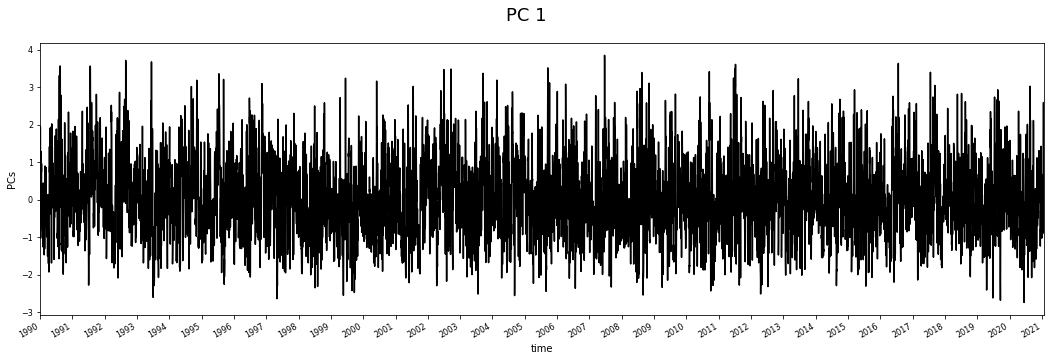


 41 PCs (0.98 expl. variance) will be used to train the model!! 



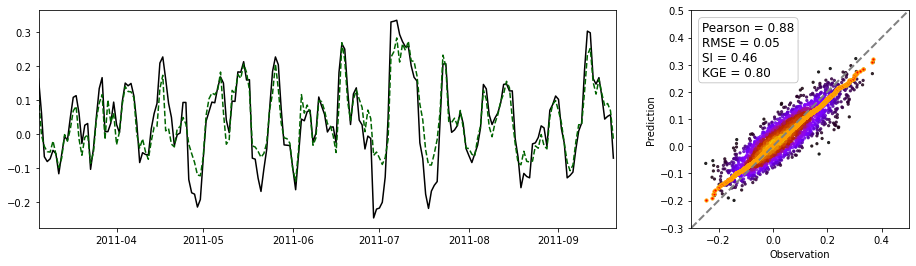

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.88, 0.76)
 NSE = [0.76446795], KGE = [0.79543256] and KGE_PRIME = [0.79826405]
 R score: 0.76 -- in TEST data

 Analyzing site 708!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 708, coords = (array(173.2418136), array(-41.23372585)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/

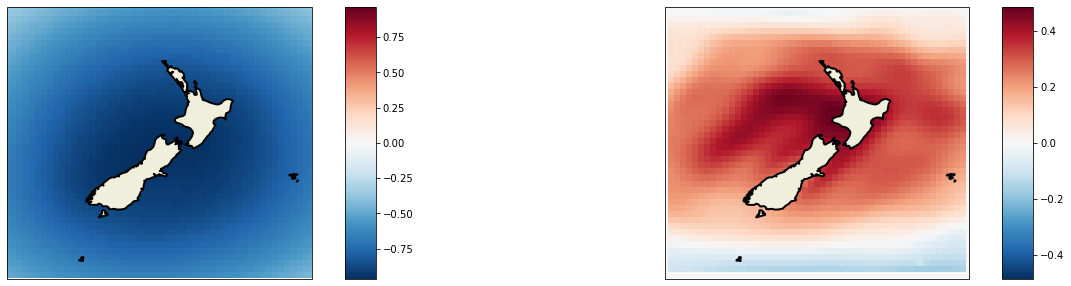

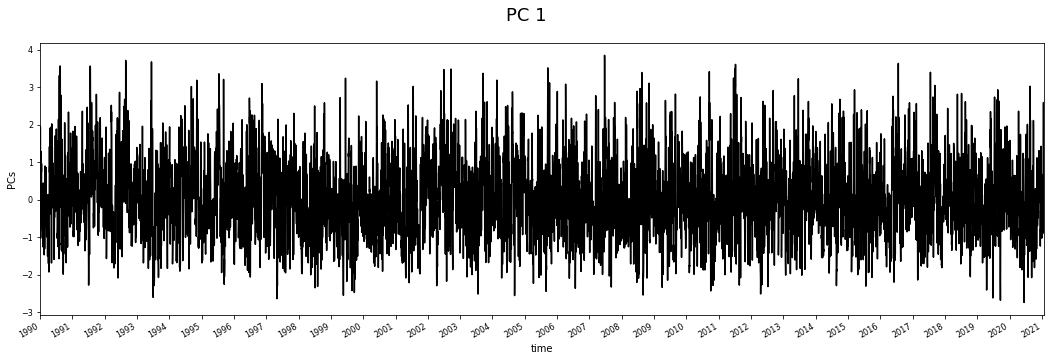


 41 PCs (0.98 expl. variance) will be used to train the model!! 



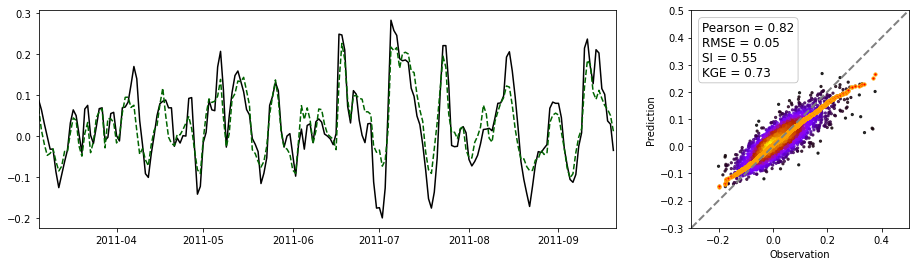

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67359185], KGE = [0.72692015] and KGE_PRIME = [0.72668049]
 R score: 0.67 -- in TEST data

 Analyzing site 744!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 744, coords = (array(173.0604534), array(-41.05019325)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss

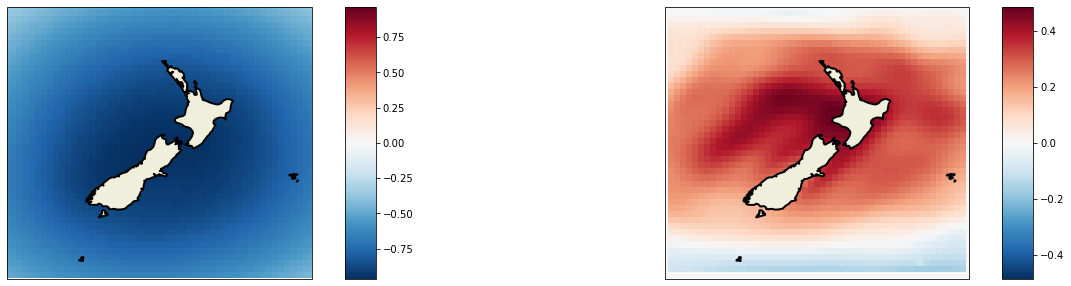

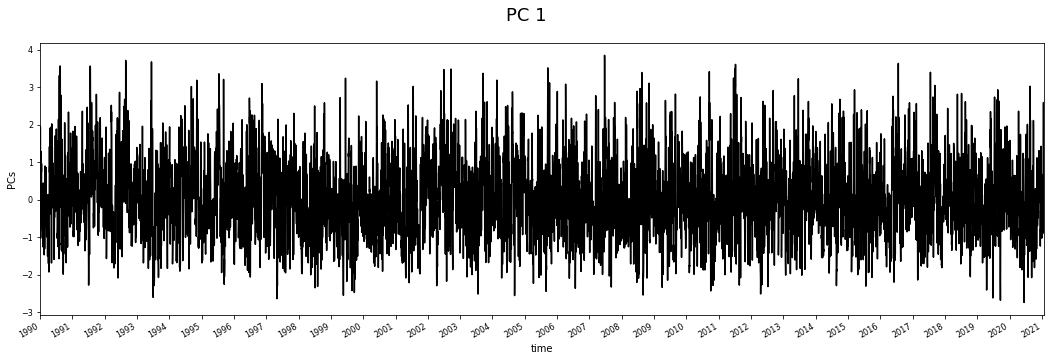


 41 PCs (0.98 expl. variance) will be used to train the model!! 



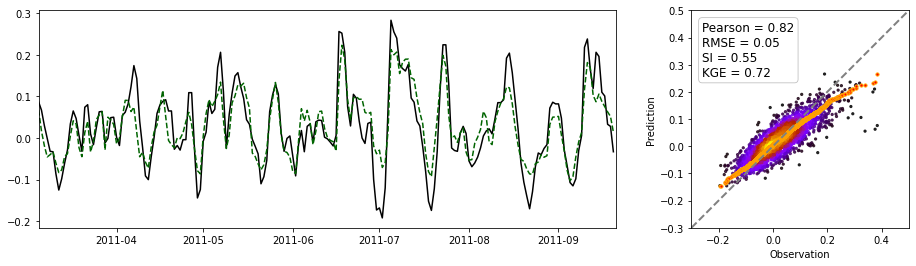

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67306171], KGE = [0.71723999] and KGE_PRIME = [0.73241343]
 R score: 0.67 -- in TEST data

 Analyzing site 780!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 780, coords = (array(176.26448363), array(-40.91220685)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss

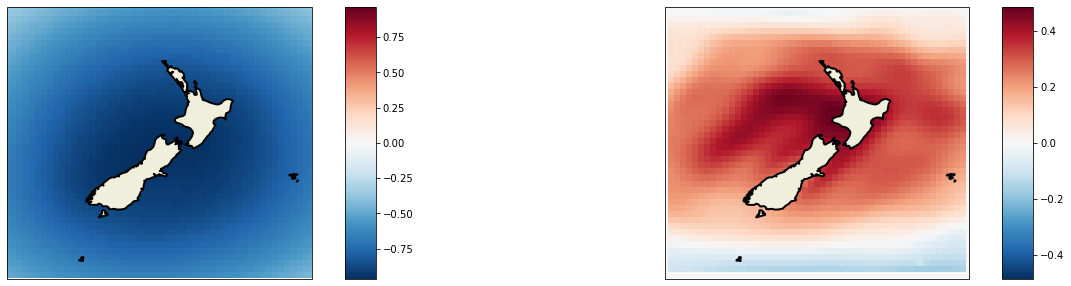

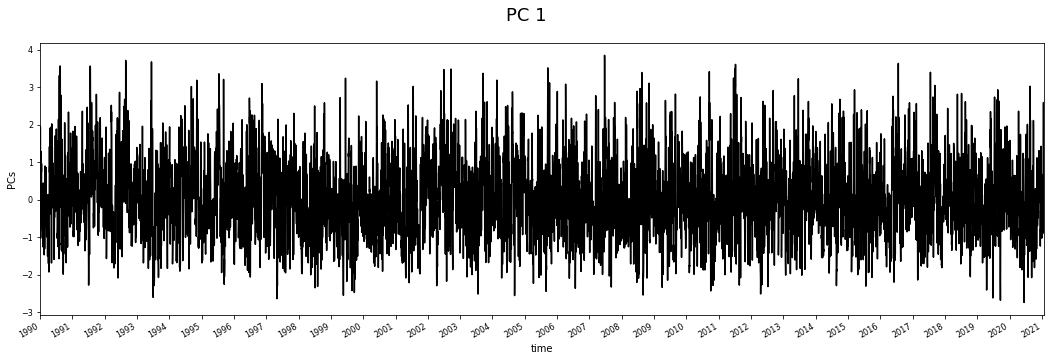


 41 PCs (0.98 expl. variance) will be used to train the model!! 



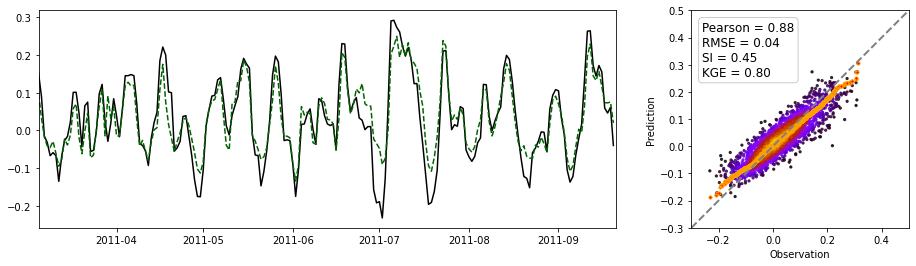

Data comparison is   --   BIAS: 0.00, SI: 0.45, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.88, 0.78)
 NSE = [0.77845367], KGE = [0.80495725] and KGE_PRIME = [0.81067641]
 R score: 0.78 -- in TEST data

 Analyzing site 803!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 803, coords = (array(172.8790932), array(-40.77393188)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/

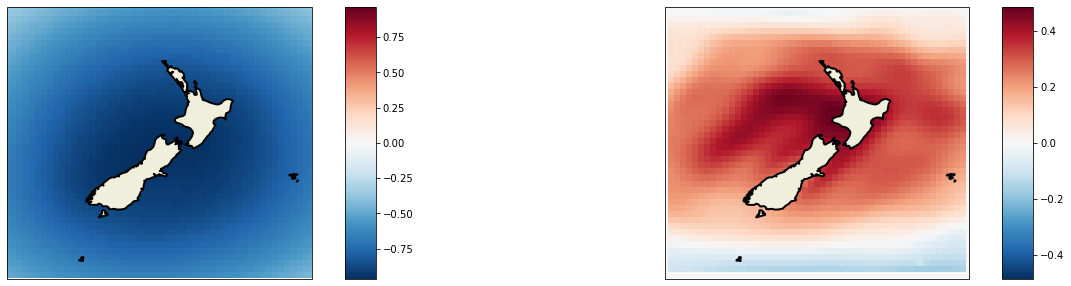

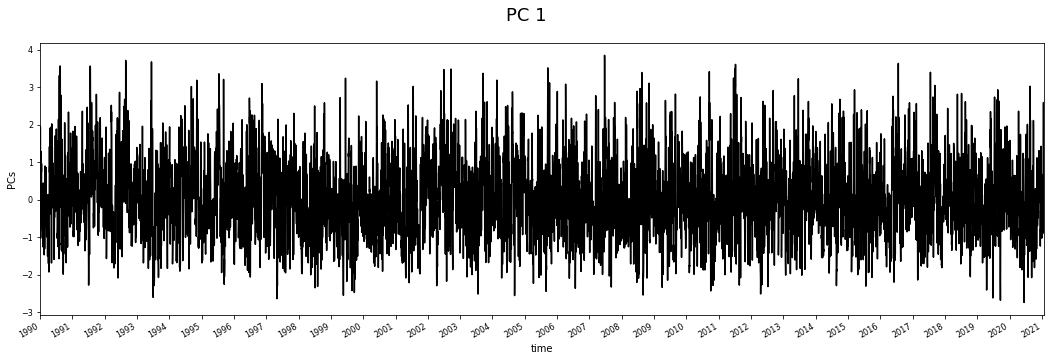


 41 PCs (0.98 expl. variance) will be used to train the model!! 



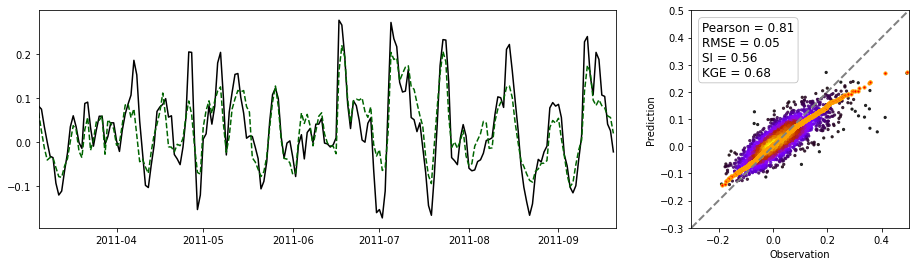

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.65740366], KGE = [0.6830306] and KGE_PRIME = [0.72909417]
 R score: 0.66 -- in TEST data

 Analyzing site 949!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 949, coords = (array(176.92947103), array(-39.46948894)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/

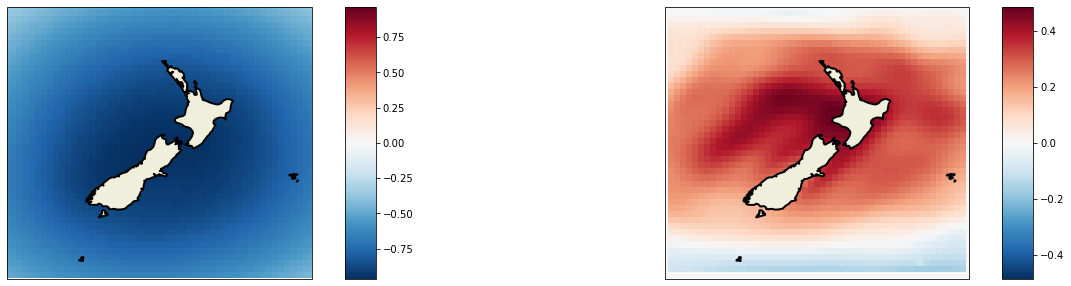

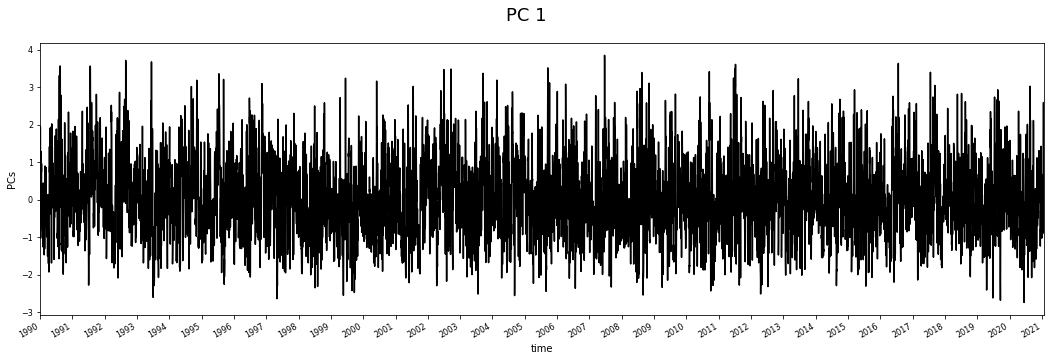


 41 PCs (0.98 expl. variance) will be used to train the model!! 



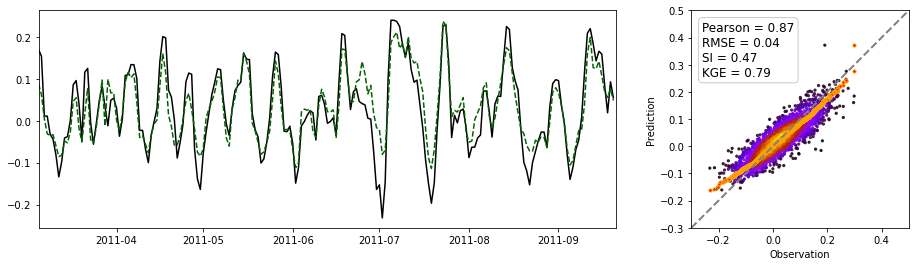

Data comparison is   --   BIAS: 0.00, SI: 0.47, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75341093], KGE = [0.78994979] and KGE_PRIME = [0.79784269]
 R score: 0.75 -- in TEST data

 Analyzing site 999!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 999, coords = (array(174.02770781), array(-39.04490025)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss

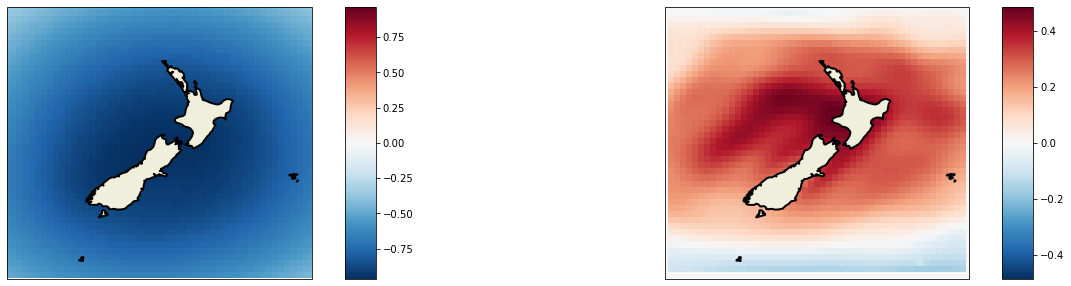

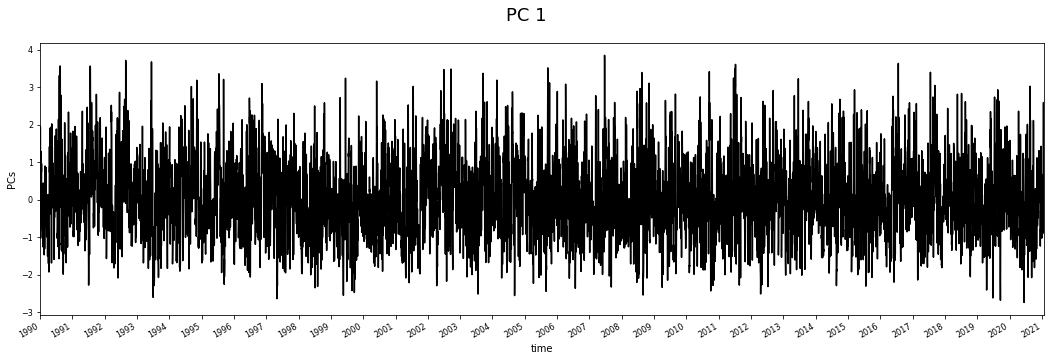


 41 PCs (0.98 expl. variance) will be used to train the model!! 



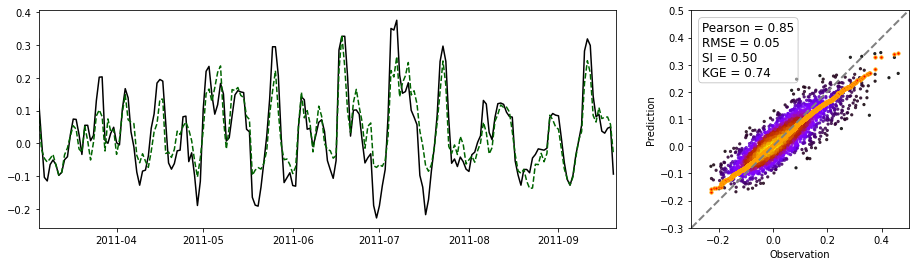

Data comparison is   --   BIAS: 0.00, SI: 0.50, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.72392097], KGE = [0.74140949] and KGE_PRIME = [0.78623167]
 R score: 0.72 -- in TEST data

 Analyzing site 1025!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1025, coords = (array(178.01763224), array(-38.71288919)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-

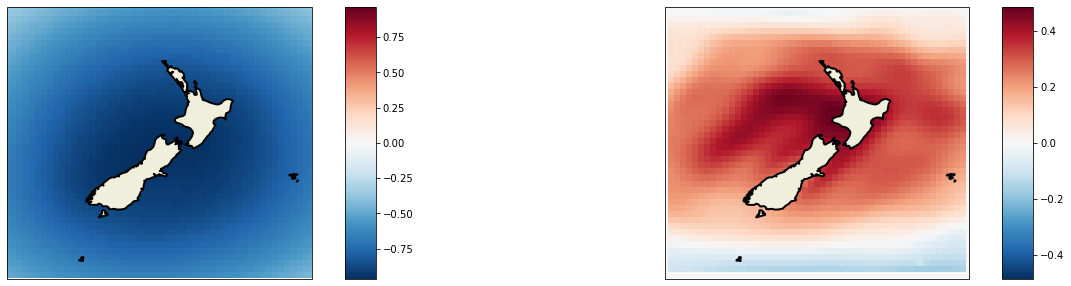

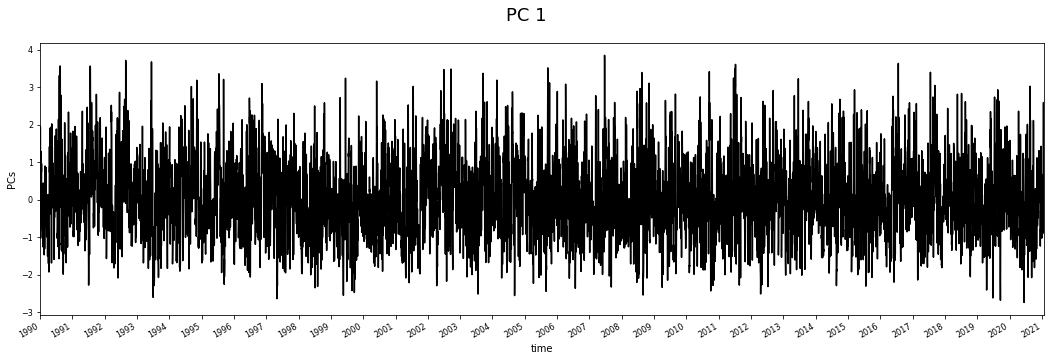


 41 PCs (0.98 expl. variance) will be used to train the model!! 



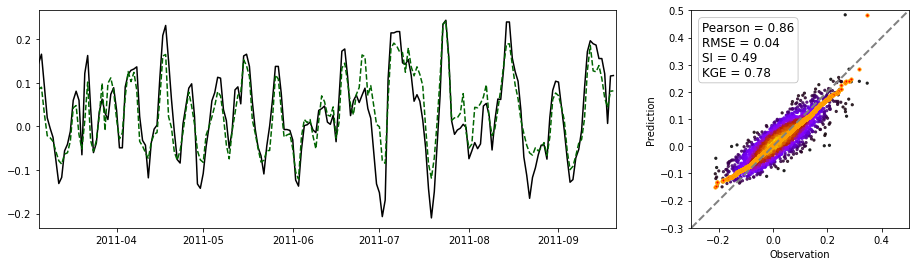

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73783266], KGE = [0.77782486] and KGE_PRIME = [0.7833816]
 R score: 0.74 -- in TEST data

 Analyzing site 1064!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1064, coords = (array(174.75314861), array(-38.04422348)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

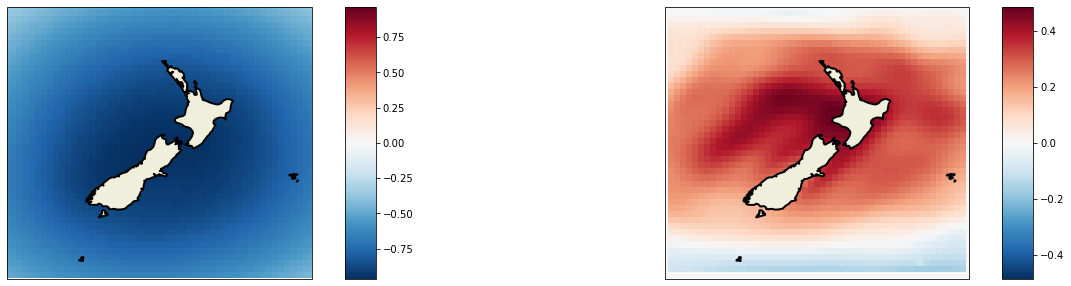

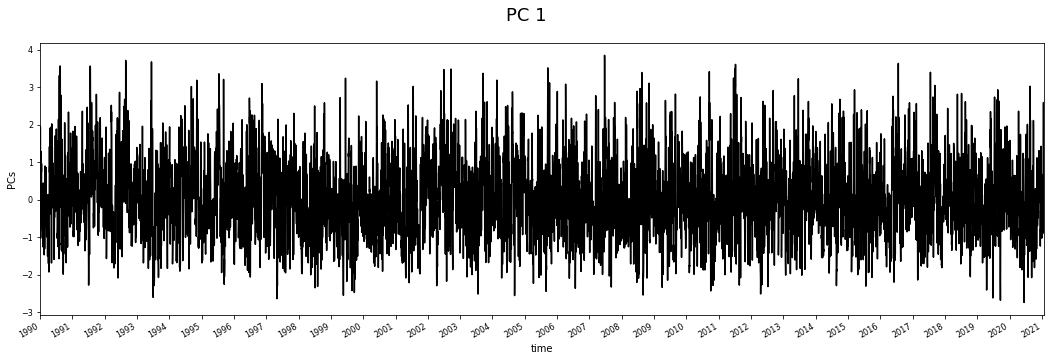


 41 PCs (0.98 expl. variance) will be used to train the model!! 



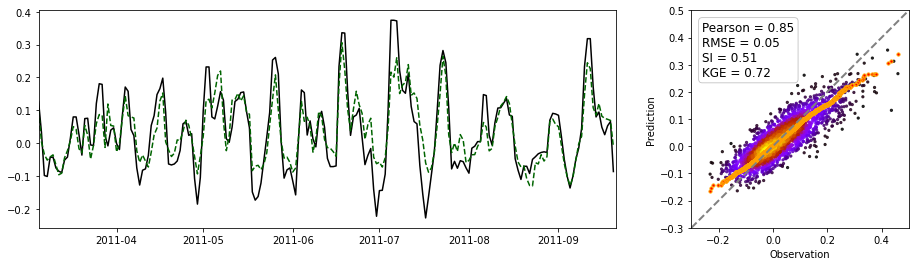

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.71)
 NSE = [0.71030219], KGE = [0.71878981] and KGE_PRIME = [0.77279612]
 R score: 0.71 -- in TEST data

 Analyzing site 1124!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1124, coords = (array(176.20403023), array(-37.61111035)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-

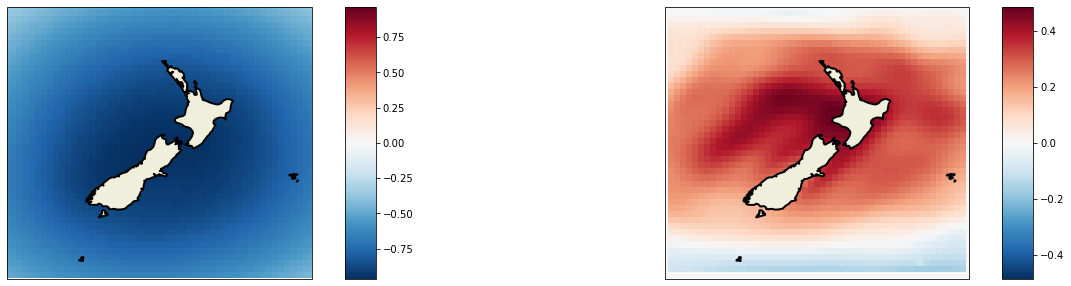

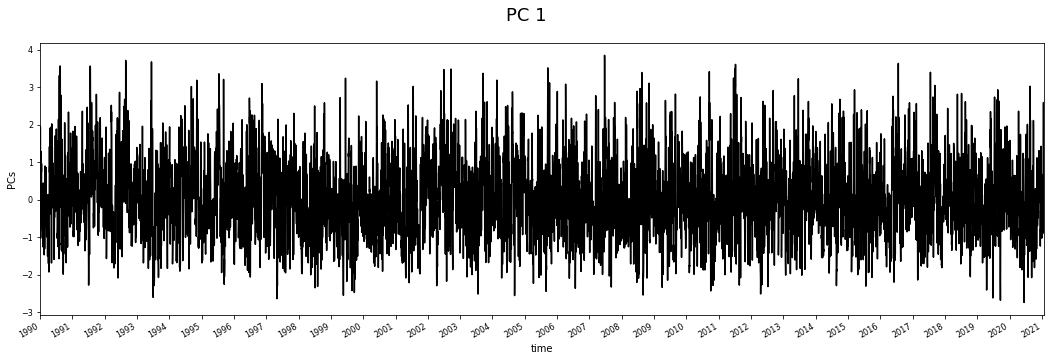


 41 PCs (0.98 expl. variance) will be used to train the model!! 



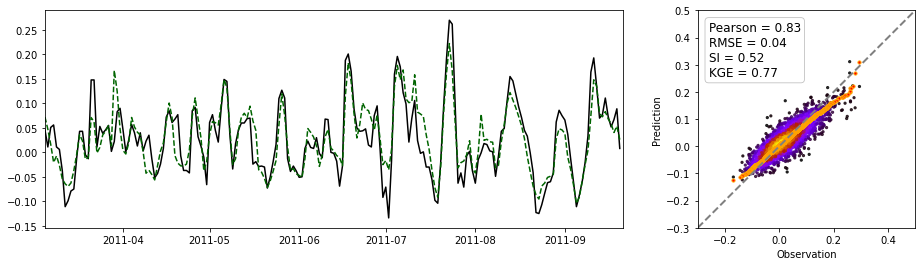

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.70)
 NSE = [0.69514669], KGE = [0.7655027] and KGE_PRIME = [0.7774187]
 R score: 0.7 -- in TEST data

 Analyzing site 1146!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1146, coords = (array(178.13853904), array(-37.51451809)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/

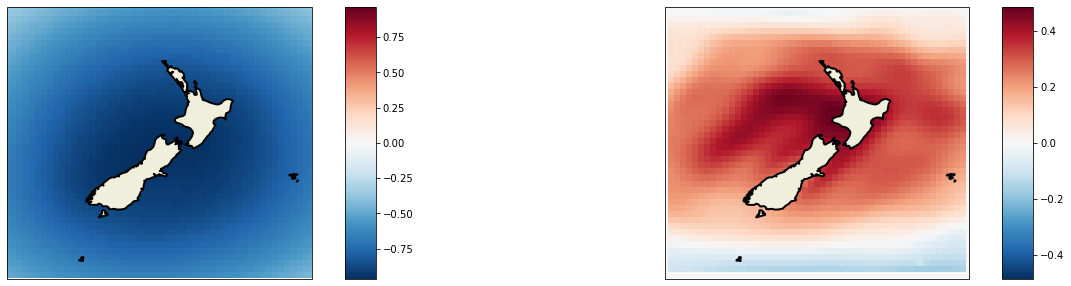

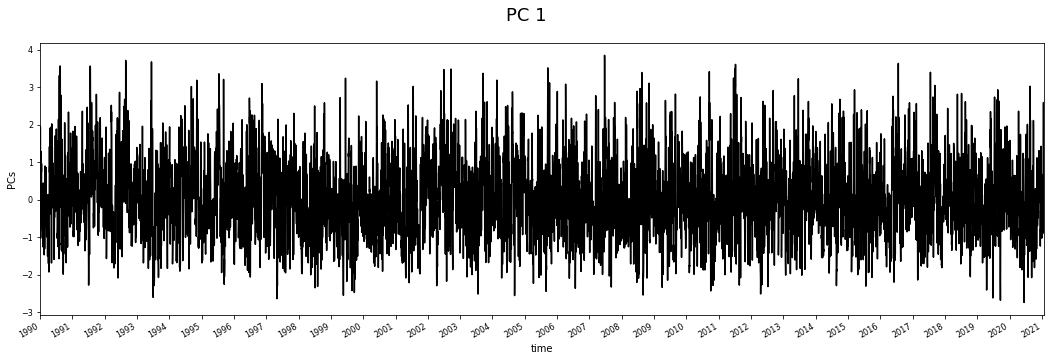


 41 PCs (0.98 expl. variance) will be used to train the model!! 



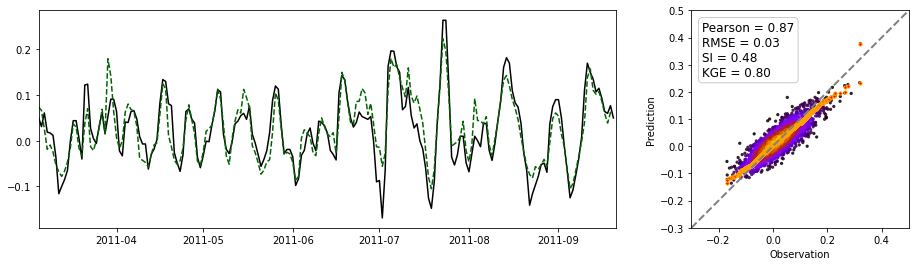

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75104073], KGE = [0.80072927] and KGE_PRIME = [0.7924352]
 R score: 0.75 -- in TEST data

 Analyzing site 1174!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1174, coords = (array(175.47858942), array(-37.12689837)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-

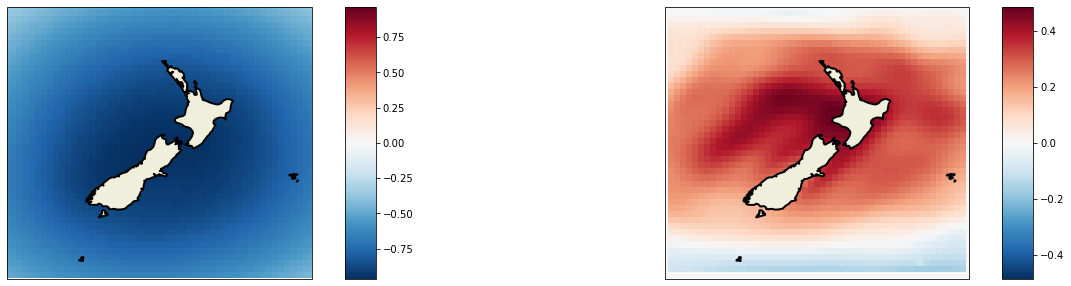

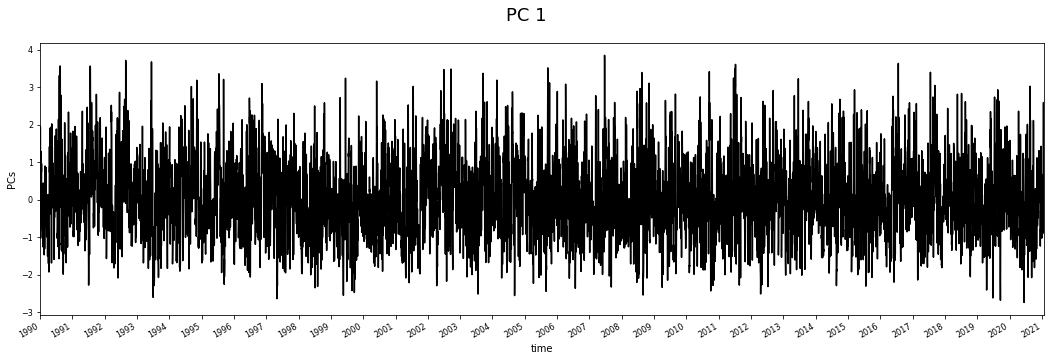


 41 PCs (0.98 expl. variance) will be used to train the model!! 



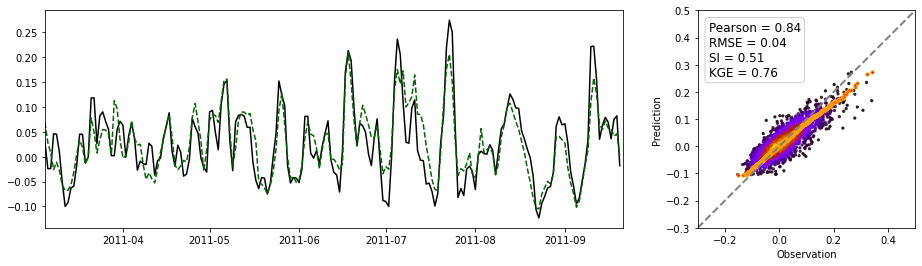

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.70947502], KGE = [0.76276891] and KGE_PRIME = [0.78697936]
 R score: 0.71 -- in TEST data

 Analyzing site 1177!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1177, coords = (array(174.51133501), array(-37.07830545)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-

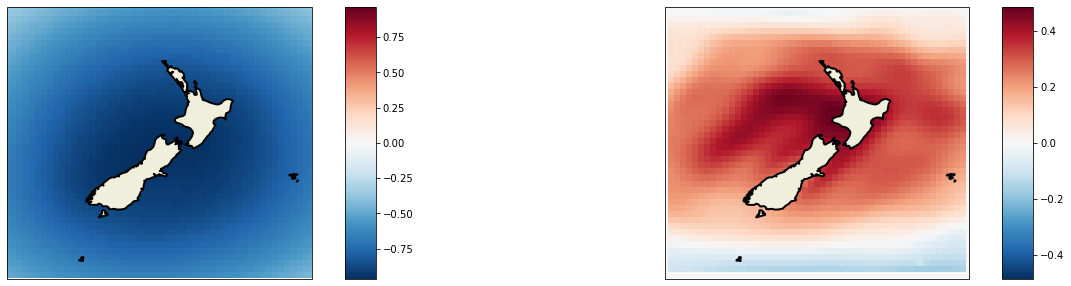

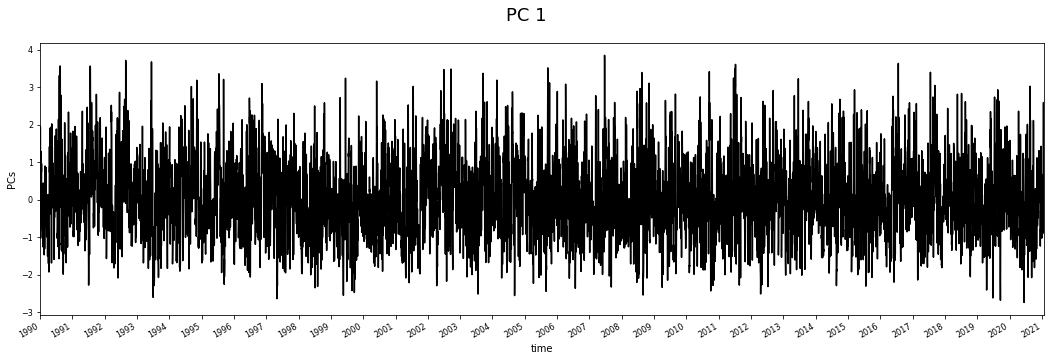


 41 PCs (0.98 expl. variance) will be used to train the model!! 



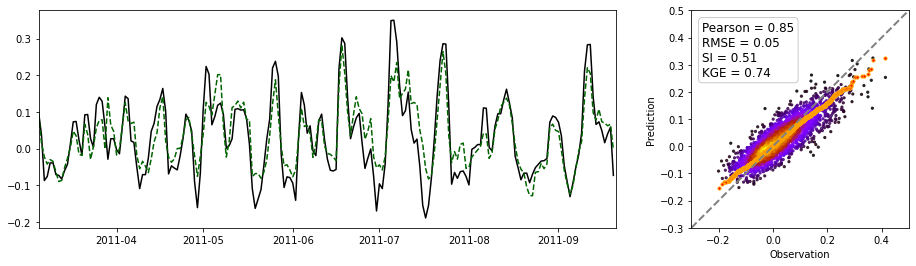

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71532907], KGE = [0.74470513] and KGE_PRIME = [0.78491211]
 R score: 0.72 -- in TEST data

 Analyzing site 1214!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1214, coords = (array(175.84130982), array(-36.83487368)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-

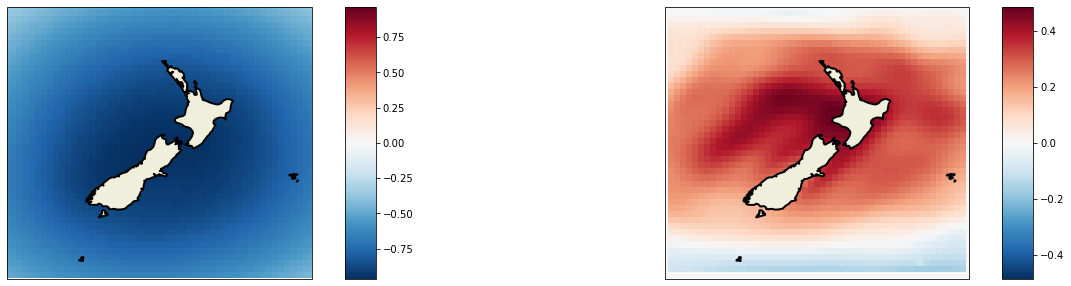

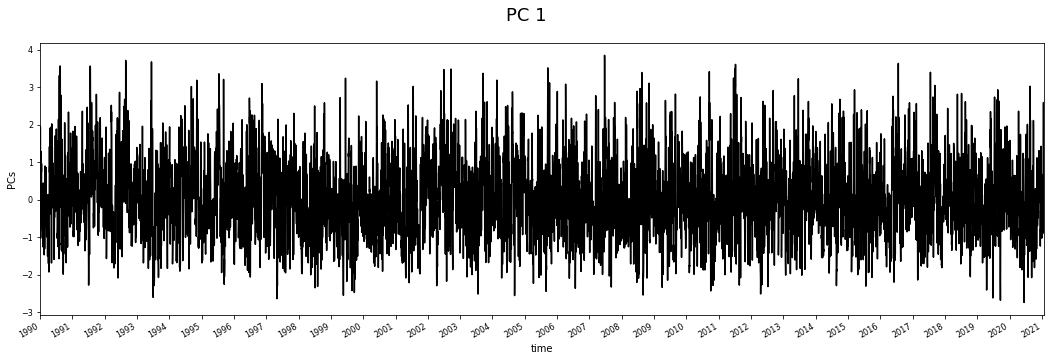


 41 PCs (0.98 expl. variance) will be used to train the model!! 



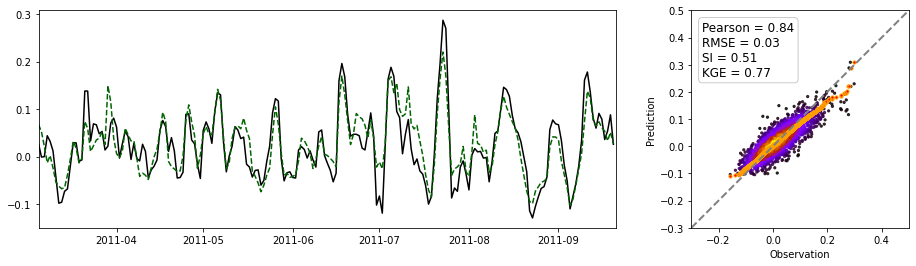

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.71084809], KGE = [0.76797269] and KGE_PRIME = [0.78246619]
 R score: 0.71 -- in TEST data

 Analyzing site 1217!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1217, coords = (array(174.81360202), array(-36.786094)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss

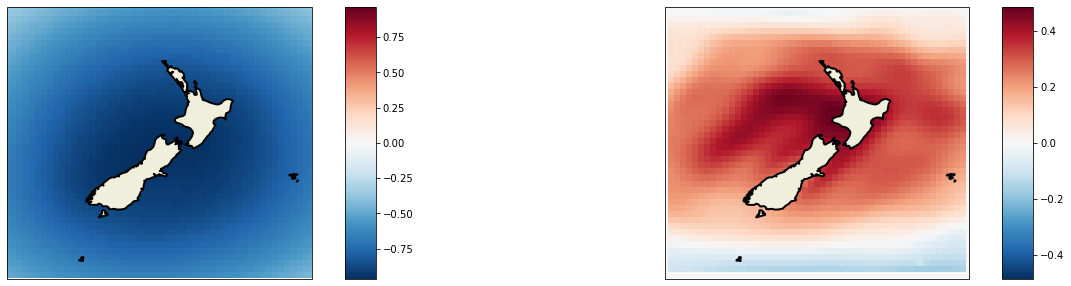

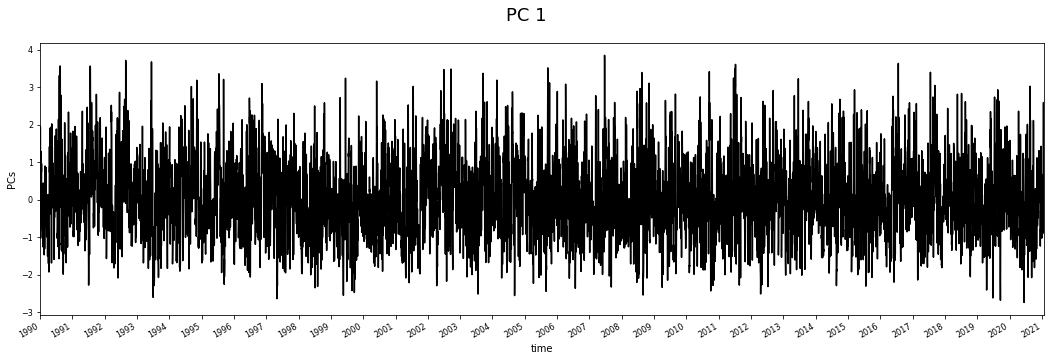


 41 PCs (0.98 expl. variance) will be used to train the model!! 



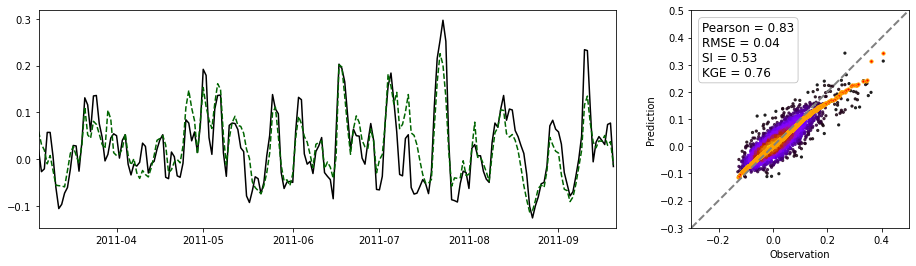

Data comparison is   --   BIAS: 0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69054681], KGE = [0.75786598] and KGE_PRIME = [0.77564105]
 R score: 0.69 -- in TEST data

 Analyzing site 1260!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1260, coords = (array(174.08816121), array(-36.44376713)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-

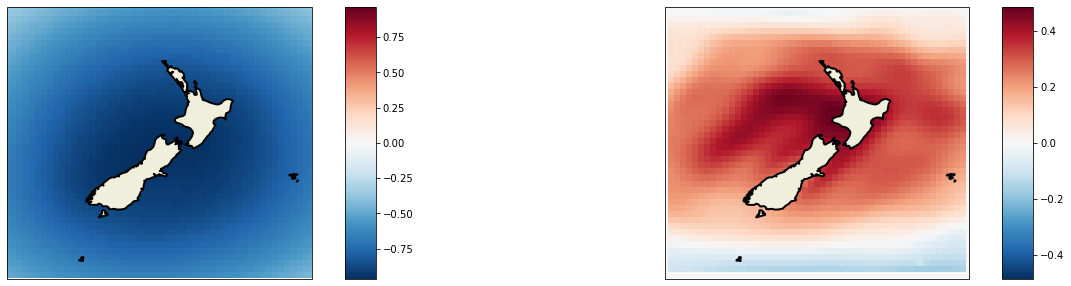

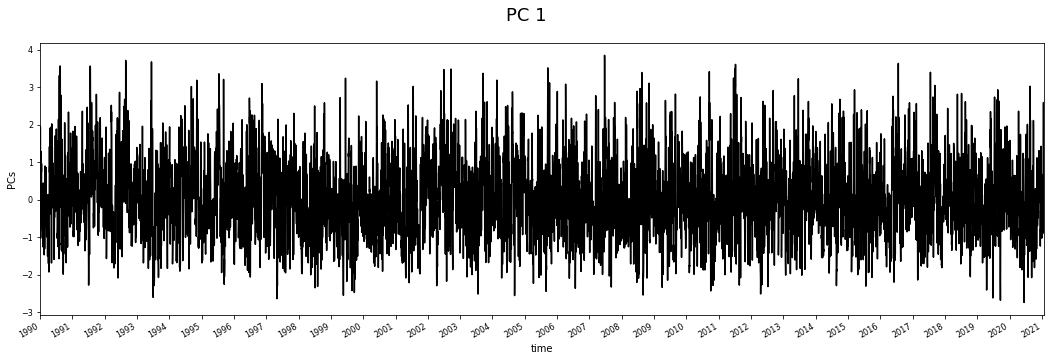


 41 PCs (0.98 expl. variance) will be used to train the model!! 



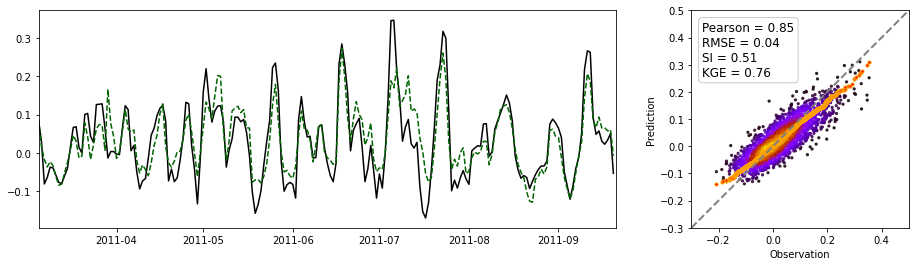

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71802095], KGE = [0.76057464] and KGE_PRIME = [0.78821106]
 R score: 0.72 -- in TEST data

 Analyzing site 1296!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1296, coords = (array(175.53904282), array(-36.1983188)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

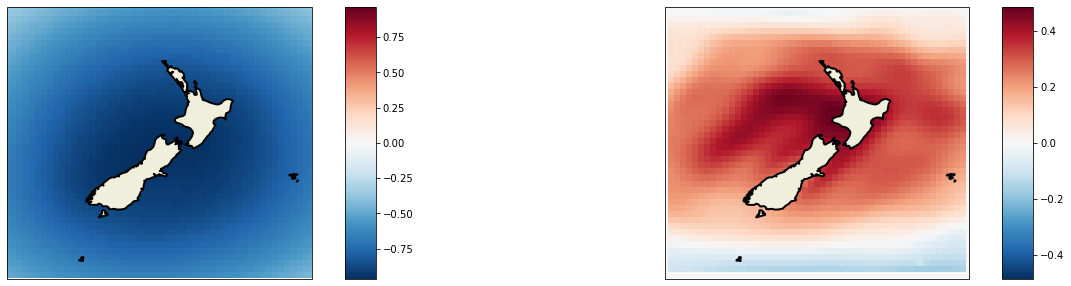

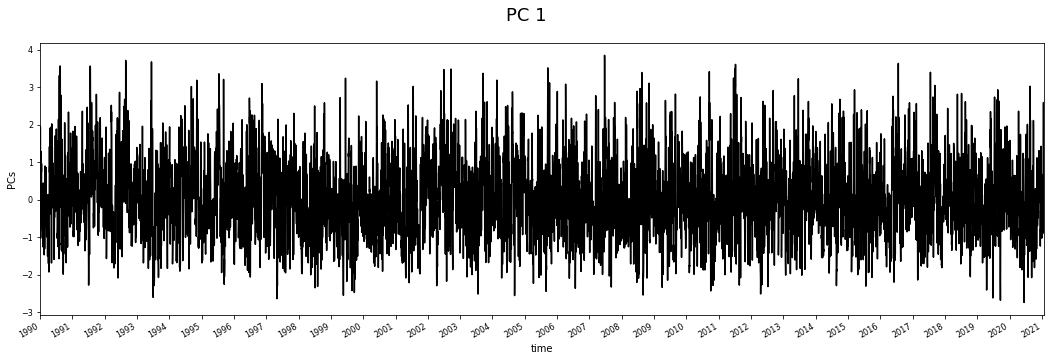


 41 PCs (0.98 expl. variance) will be used to train the model!! 



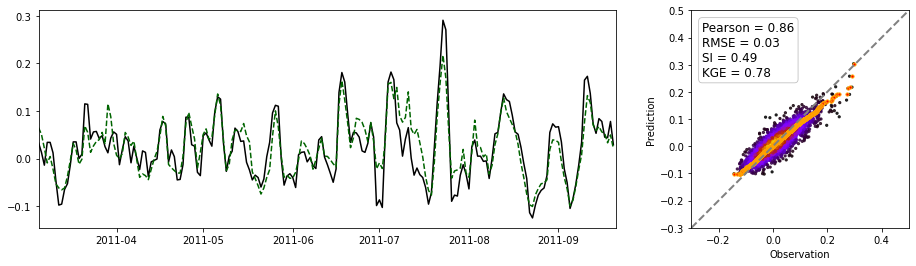

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73683596], KGE = [0.78281553] and KGE_PRIME = [0.7931799]
 R score: 0.74 -- in TEST data

 Analyzing site 1327!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1327, coords = (array(174.51133501), array(-35.90276205)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

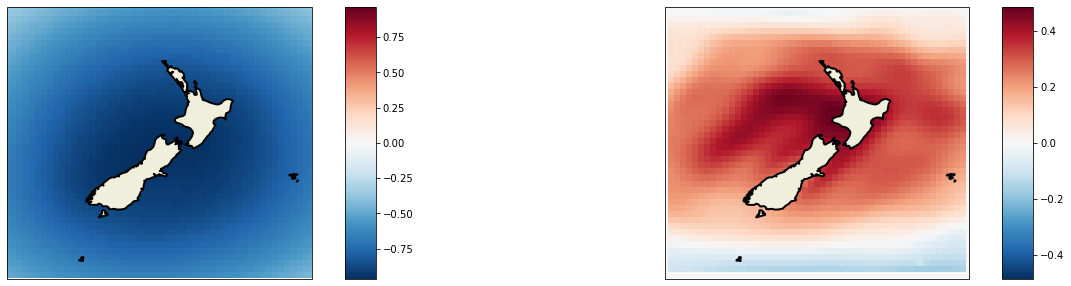

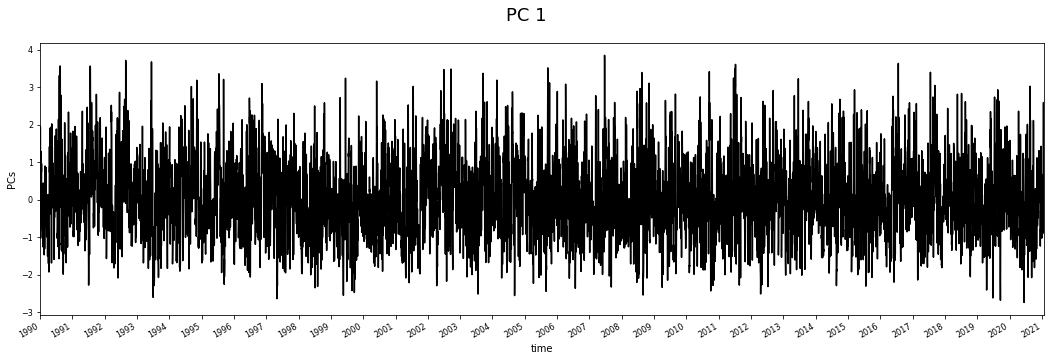


 41 PCs (0.98 expl. variance) will be used to train the model!! 



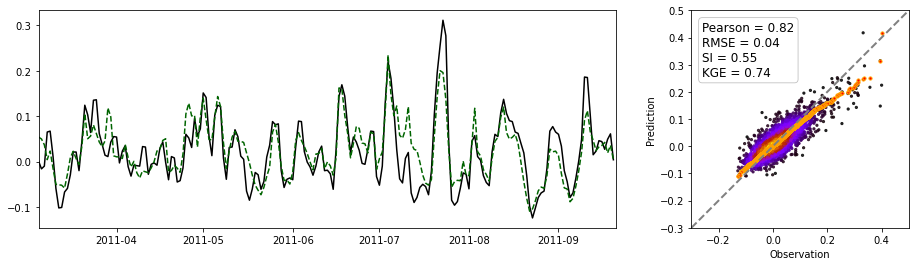

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67418438], KGE = [0.74306882] and KGE_PRIME = [0.74322311]
 R score: 0.67 -- in TEST data

 Analyzing site 1442!! 


 ---------------------------------------------------------                         

 Experiment 1 in site 1442, coords = (array(173.0604534), array(-34.40843867)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -52, -30))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
False
/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-s

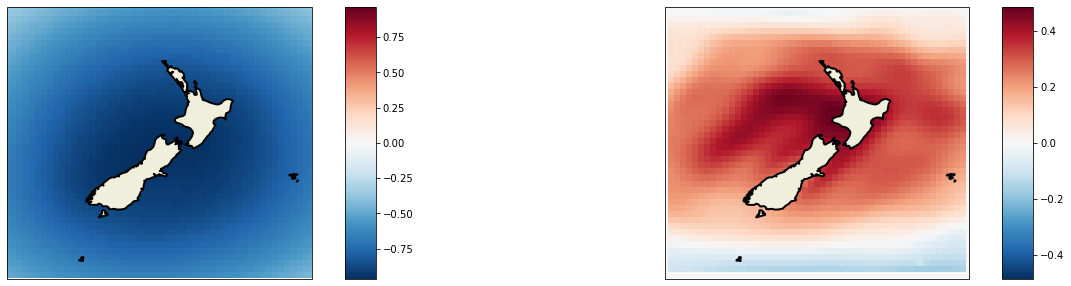

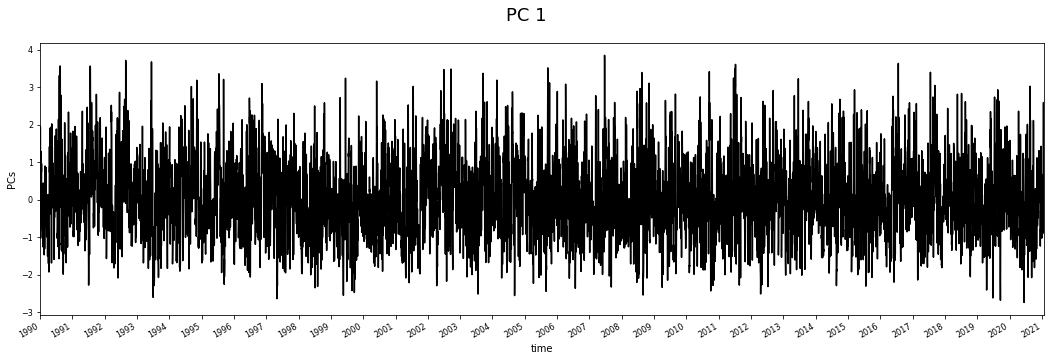


 41 PCs (0.98 expl. variance) will be used to train the model!! 



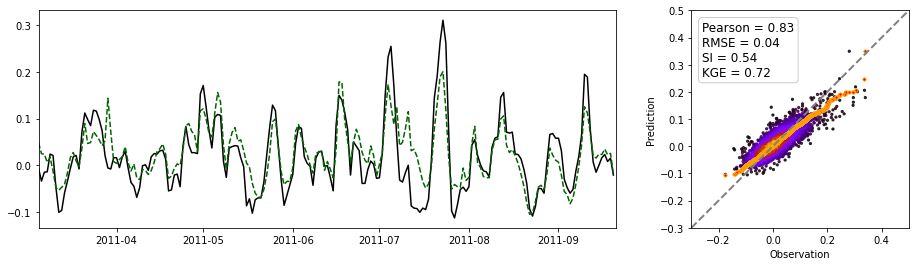

Data comparison is   --   BIAS: 0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68100641], KGE = [0.71670935] and KGE_PRIME = [0.72132826]
 R score: 0.68 -- in TEST data

 -------------------------------------------------------------------             

 All the models and in all the sites have been correctly calculated!!             

 with a final mean stats (in the sites) with the following shape...             

 BIAS, SI, RMSE, Pearson and Spearman coorelations and the R2 score... 

 [[[[[[[[-9.97905114e-05  5.08093272e-01  4.63012176e-02
         2.55434919e-01  7.07221010e-02  8.21768238e-02
         1.08648217e-01  2.39305632e-01  2.52422650e-01
         2.91802001e-01  8.45227306e-01  7.13771795e-01
         8.35333494e-01  5.59252900e-01  5.08223316e-01
         2.82060286e-01 -1.17250583e+00 -2.55056717e+00
        -9.62575574e+00  5.08617528e-01  4.84250881e-01
         2.65082345e-01  7.99028729e+01  5.68552778e-01
        

In [13]:
# run all the models
exp_parameters, exp_mean_parameters, stats_keys = experiment.execute_cross_model_calculations(
    verbose=True, plot=True # plot logs when computing the models
)

In [10]:
# finally, we can save the results, using the following function
def save_final_results(to_save_name: str = 
    '../data/statistics/experiments/experiment_linear_superfinal_15062022.nc'):
    
    """
        This function saves the results in netCDF4 format
    """
    
    region_labels = ['local_1.5_1.5','local_2.5_2.5','default_region_reduced']
    coords_dict = {'grad': pca_attrs_exp['calculate_gradient'],
                   'winds': pca_attrs_exp['winds'],
                   'tlapse': pca_attrs_exp['time_lapse'],
                   'tresample': pca_attrs_exp['time_resample'],
                   'region': region_labels,
                   'tsize': linear_attrs_exp['train_size'],
                   'perpcs': linear_attrs_exp['percentage_PCs']}
    
    sites_datasets = [] # save all xarray.Dataset's in sites
    for i,site,exp_metrics_site in zip(range(len(experiment.ss_sites)),
                                       experiment.ss_sites,
                                       exp_parameters):
        site_metrics = {}
        for im,metric in enumerate(stats_keys):
            site_metrics[metric] = (
                ('grad','winds','tlapse','tresample','region','tsize','perpcs'),
                # TODO: add here : depending on the MODEL in the experiments
                # ----------------------------------------------------------
                 exp_parameters[i][:,:,:,:,:,:,:,im])
                # ----------------------------------------------------------
        experiment_metrics = xr.Dataset(site_metrics).assign(coords_dict)\
            .expand_dims({'site':[site]})
        sites_datasets.append(experiment_metrics)
    experiment_metrics = xr.concat(sites_datasets,dim='site')
    # experiment_metrics.to_netcdf(to_save_name)
    
    return experiment_metrics

In [ ]:
results = save_final_results()

In [30]:
print('DONE!!')

DONE!!
